## Многофакторная модель повторных измерений

In [1]:
%pylab inline
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

Populating the interactive namespace from numpy and matplotlib


Одним отважным зоологом, любящим ос настолько, что позволяет им жалить себя, тест "Баланс внимания" был повторен в [следующих условиях](http://balatte.stireac.com/result/anarchist123@rambler.ru):
- [в норме](http://balatte.stireac.com/result/anarchist123%40rambler.ru/213.138.81.168__0201351930130528)
- [5 минут после укуса](http://balatte.stireac.com/result/anarchist123%40rambler.ru/213.138.81.168__1249300420130528)
- [полчаса после укуса](http://balatte.stireac.com/result/anarchist123%40rambler.ru/213.138.81.168__2227196800130528)
- [два часа после укуса](http://balatte.stireac.com/result/anarchist123%40rambler.ru/213.138.81.168__2254147640130528)

Тест был проведен лишь однажды, поэтому говорить о научной новизне полученных результатов не приходится. Однако для демонстрации статистического анализа данные прекрасно подходят.


In [2]:
u = 'http://data.stireac.com/homo/anarchist123@rambler.ru/balatte/_stat.json'

oo=pd.read_json(u,'values')
oo[['conditio','kv','ka','bv','ba','n','t']]

,conditio,kv,ka,bv,ba,n,t
0,,0.009942,0.006134,0.326625,0.361183,48,2013-03-16 08:43
1,внимание в норме,0.033121,0.015190,0.208891,0.288200,48,2013-05-28 19:57
2,5 минут после укуса,-0.018238,-0.007856,0.541942,0.601157,48,2013-05-28 21:45
3,спустя полчаса после укуса,-0.112809,0.016975,0.854461,0.736766,48,2013-05-28 22:23
4,спустя два часа после укуса,0.019278,0.021591,0.279309,0.294362,48,2013-05-28 22:50


Судя по времени теста, последний раз тест проходил спустя час после воздействия, которое произошло примерно в 21:40.

Чтобы не вводить отрицательное значение для контроля - зададим значение 120 мин, предполагая, что через два часа эффект от воздействия полностью исчезает, и такое состояние совпадает с контрольным.

In [3]:
S = oo.ix[1:,['conditio','kv','ka','bv','ba']]
S['delay'] = ([120,5,30,60])
S

,conditio,kv,ka,bv,ba,delay
1,внимание в норме,0.033121,0.015190,0.208891,0.288200,120
2,5 минут после укуса,-0.018238,-0.007856,0.541942,0.601157,5
3,спустя полчаса после укуса,-0.112809,0.016975,0.854461,0.736766,30
4,спустя два часа после укуса,0.019278,0.021591,0.279309,0.294362,60


Значения коэффициентов `k` и `b` у нас присутствуют в разных колонках. Объедим их, для чего создадим колонку с указанием модальности.

In [4]:
momo = tile(array([['v','a']]).T, (S.shape[0])).ravel()
momo

array([u'v', u'v', u'v', u'v', u'a', u'a', u'a', u'a'], 
      dtype='<U1')

In [5]:
D=pd.DataFrame({
    'k': S['kv'].append(S['ka']),
    'b': S['bv'].append(S['ba']),
    'mod':momo,
    'delay': tile(log(S.delay), 2),
    })['b k mod delay'.split()]  #неалфавитный порядок столбцов
D

,b,k,mod,delay
1,0.208891,0.033121,v,4.787492
2,0.541942,-0.018238,v,1.609438
3,0.854461,-0.112809,v,3.401197
4,0.279309,0.019278,v,4.094345
1,0.288200,0.015190,a,4.787492
2,0.601157,-0.007856,a,1.609438
3,0.736766,0.016975,a,3.401197
4,0.294362,0.021591,a,4.094345


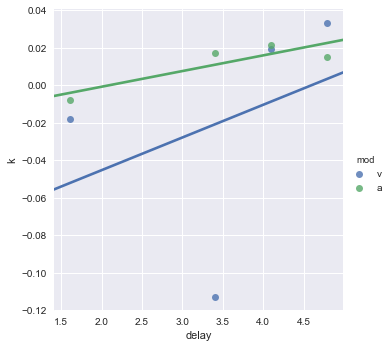

In [22]:
sns.lmplot('delay','k',D, hue='mod', ci=None);

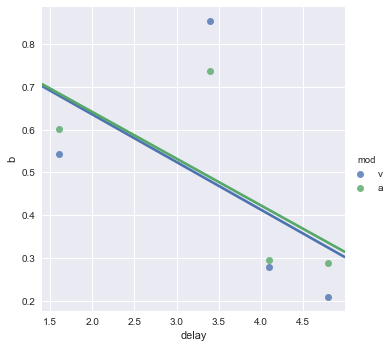

In [23]:
sns.lmplot('delay','b',D, hue='mod', ci=None);

На рисунках прослеживается некоторая зависимость показателей от времени, прошедшего после воздействия.

На обоих рисунках из общего тренда выпадают значения второго измерения (спустя 30 мин после укуса). Поскольку подробностей мы не знаем, предположим в качестве рабочей гипотезы, что эти изменения возникли вследствие воздействия.

In [42]:
result = smf.ols('b ~ delay*mod -1', data=D).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      b   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                 -0.166
Method:                 Least Squares   F-statistic:                    0.6670
Date:                Fri, 10 Mar 2017   Prob (F-statistic):              0.615
Time:                        15:03:05   Log-Likelihood:                 2.1598
No. Observations:                   8   AIC:                             3.680
Df Residuals:                       4   BIC:                             3.998
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
mod[a]             0.8600      0.405      2.122      0.101        -0.265     1.985
mod[v]             0.8583      0.405      2.118      0.102        -0.267     1.984
delay             -0.1094      0.110     -0.990      0.378        -0.416     0.197
delay:mod[T.v]    -0.0021      0.156     -0.013      0.990        -0.436     0.432
==============================================================================
Omnibus:                        4.224   Durbin-Watson:                   2.791
Prob(Omnibus):                  0.121   Jarque-Bera (JB):                1.928
Skew:                           1.189   Prob(JB):                        0.381
Kurtosis:                       2.649   Cond. No.                         20.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Влияние модальности и задержки на коэффициент b недостоверно.

In [44]:
result = smf.ols('k ~ delay*mod -1', data=D).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      k   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                 -0.293
Method:                 Least Squares   F-statistic:                    0.4717
Date:                Fri, 10 Mar 2017   Prob (F-statistic):              0.718
Time:                        15:04:06   Log-Likelihood:                 14.861
No. Observations:                   8   AIC:                            -21.72
Df Residuals:                       4   BIC:                            -21.40
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
mod[a]            -0.0176      0.083     -0.212      0.842        -0.248     0.212
mod[v]            -0.0803      0.083     -0.969      0.387        -0.310     0.150
delay              0.0084      0.023      0.371      0.730        -0.054     0.071
delay:mod[T.v]     0.0091      0.032      0.285      0.790        -0.080     0.098
==============================================================================
Omnibus:                       12.195   Durbin-Watson:                   2.772
Prob(Omnibus):                  0.002   Jarque-Bera (JB):                4.210
Skew:                          -1.598   Prob(JB):                        0.122
Kurtosis:                       4.554   Cond. No.                         20.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Влияние модальности и задержки на коэффициент k недостоверно.

Оценить отклонения от модели и влияние отдельных точек можно графически.

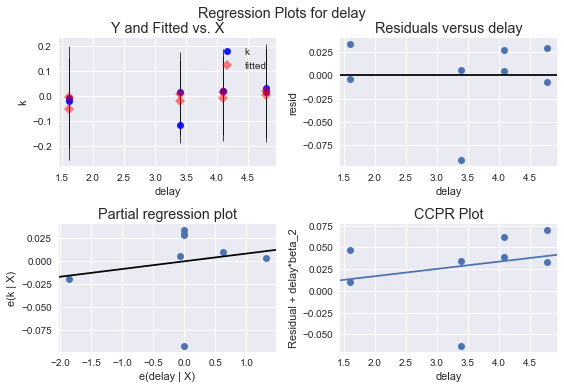

In [45]:
sm.graphics.plot_regress_exog(result, 'delay');

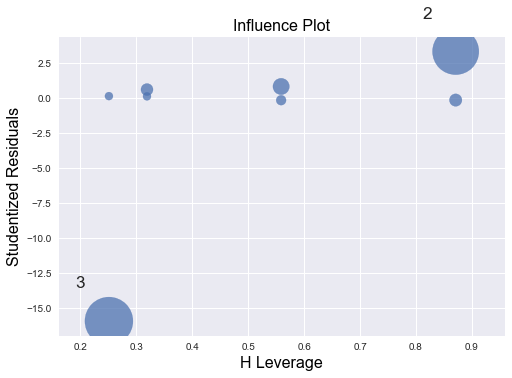

In [46]:
sm.graphics.influence_plot(result);

Если влиянием модальности пренебречь, можно оценить влияние на ускорение реакции только величины задержки.

In [47]:
result = smf.ols('b ~ delay', data=D).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      b   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     2.996
Date:                Fri, 10 Mar 2017   Prob (F-statistic):              0.134
Time:                        15:08:13   Log-Likelihood:                 2.1572
No. Observations:                   8   AIC:                           -0.3145
Df Residuals:                       6   BIC:                           -0.1556
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.8592      0.234      3.671      0.010         0.286     1.432
delay         -0.1104      0.064     -1.731      0.134        -0.267     0.046
==============================================================================
Omnibus:                        3.958   Durbin-Watson:                   2.794
Prob(Omnibus):                  0.138   Jarque-Bera (JB):                1.857
Skew:                           1.162   Prob(JB):                        0.395
Kurtosis:                       2.584   Cond. No.                         12.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
result = smf.ols('k ~ delay', data=D).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      k   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                 -0.026
Method:                 Least Squares   F-statistic:                    0.8242
Date:                Fri, 10 Mar 2017   Prob (F-statistic):              0.399
Time:                        15:09:18   Log-Likelihood:                 14.164
No. Observations:                   8   AIC:                            -24.33
Df Residuals:                       6   BIC:                            -24.17
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -0.0489      0.052     -0.938      0.385        -0.177     0.079
delay          0.0129      0.014      0.908      0.399        -0.022     0.048
==============================================================================
Omnibus:                       21.295   Durbin-Watson:                   2.183
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                9.079
Skew:                          -2.172   Prob(JB):                       0.0107
Kurtosis:                       5.891   Cond. No.                         12.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Полученную модель можно записать в виде формулы:

$$k = 0.013 log(t) - 0.049$$

где $k$ - коэффициент чувствительности к ритму стимуляции (угол наклона зависимости ВР от логарифма МСИ в тесте на внимание), $t$ - время после воздействия